In [ ]:
# Prepare env in collab
!pip install python-mnist
!mkdir mnist 
!cd mnist && wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz && wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!cd mnist && gzip -d train-images-idx3-ubyte.gz && gzip -d train-labels-idx1-ubyte.gz

In [239]:
import typing as tp
import math
import multiprocessing
from copy import deepcopy
from multiprocessing import Pool
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import multivariate_normal
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from mnist import MNIST

In [3]:
T = tp.TypeVar('T')

# Binary search tolerance constant
EPS = 0.001

def binary_real_search(func: tp.Callable[[T], float], value: float, initial: T) -> T:
    """Binary real search for monotonous real functions"""
    if isinstance(initial, float) or isinstance(initial, int):
        left, right = 1, 1
    else:
        left = np.ones((initial.shape))
        right = np.ones((initial.shape))

    while func(left) >= value:
        left = left / 2

    while func(right) <= value:
        right = right * 2

    while (right - left) > EPS:
        mid = (left + right) / 2
        if func(mid) == value:
            return mid

        if func(mid) > value:
            right = mid
        else:
            left = mid

    return mid

In [191]:
class HighDimensionDataSet:
    """High-dimenstion dataset with normal distributed conditional probs.
    Compute sigma with binary real search depending on perplexity parameter
    """
    DEFAULT_SIGMA = 1 / math.sqrt(2)
    MAX_PERPLEXITY = 1000
    MAX_SIGMA = 10

    def __init__(self, X: tp.Any, perplexity: int):
        self.points = X
        self.probs = np.zeros((len(self), self.dim))
        self.sigma = np.ones(len(self)) * self.DEFAULT_SIGMA
        self.perplexity = perplexity
        self.entropy = np.zeros(len(self))
        self.probs = np.zeros((len(self), len(self)))

        self._cond_probs = np.zeros((len(self), len(self)))

    def __len__(self) -> int:
        return self.points.shape[0]

    @property
    def dim(self) -> int:
        return self.points.shape[1]

    def fit(self) -> None:
        self._update_conditional_probs()
        self._update_entropy()

        self._fit_sigma()
        self._update_probs()

        self._check_fitted_model()

    @staticmethod
    def density(x1: tp.Any, x2: tp.Any, sigma: float) -> float:
        return math.exp((np.linalg.norm(x1 - x2) ** 2) / (-2 * (sigma ** 2)))

    def _update_probs(self) -> None:
        points_number = len(self)

        for i in range(points_number):
            for j in range(points_number):
                self.probs[i, j] = (self._cond_probs[i, j] + self._cond_probs[j, i]) / (2 * points_number)

    def _update_entropy(self) -> None:
        for i in range(len(self)):
            self._update_entropy_by_idx(i)

    def _update_entropy_by_idx(self, idx: int) -> None:
        res = 0
        for j in range(len(self)):
            if not self._cond_probs[j, idx]:
                continue
            res -= self._cond_probs[j, idx] * math.log2(self._cond_probs[j, idx])
        self.entropy[idx] = res

    def _update_conditional_probs(self) -> None:
        for i in range(len(self)):
            self._update_cond_probs_by_idx(i)

    def _update_cond_probs_by_idx(self, idx: int) -> None:
        sigma = self.sigma[idx]
        b = sum(
            [
                self.density(self.points[idx], self.points[k], sigma)
                for k in range(len(self)) if k != idx
            ]
        )
        for j in range(len(self)):
            if idx == j:
                continue
            a = self.density(self.points[idx], self.points[j], sigma)

            assert a <= b, "Conditional proba must be not greather 1"

            self._cond_probs[j, idx] = a / b if b > 0 else 0

    def _fit_sigma(self) -> None:
        for i in tqdm(range(len(self)), desc="Fitting conditional probs"):
            self.sigma[i] = math.fabs(binary_real_search(self._entropy_by_idx(i), self.perplexity, self.DEFAULT_SIGMA))

    def _entropy_by_idx(self, i) -> tp.Callable[[tp.Any], float]:
        def func(sigma):
            default_max_value = self.MAX_PERPLEXITY * 2

            if sigma > self.MAX_SIGMA:
                return default_max_value

            self.sigma[i] = math.fabs(sigma)
            self._update_cond_probs_by_idx(i)
            self._update_entropy_by_idx(i)
            entropy = self.entropy[i]

            if entropy > math.log2(self.MAX_PERPLEXITY) + 1:
                return default_max_value

            return 2 ** entropy

        return func

    def _check_fitted_model(self):
        self._check_cond_probs()
        self._check_entropy()

    def _check_cond_probs(self):
        shape = self._cond_probs.shape

        assert shape == (len(self), len(self)), f"Invalid cond probs shape, expected = {(len(self), len(self))}, actual = {shape}"

        tolerance = 1e-2
        for i in range(len(self)):
            column_sum = np.sum(self._cond_probs[:, i])

            assert math.fabs(1 - column_sum) < tolerance, f"Column cond probs sum must be 1, but got {column_sum}"
            assert self._cond_probs[i][i] == 0, f"Diaganal elements must be 0, but got {self.cond_probs[i][i]}"

    def _check_entropy(self):
        tolerance = 1
        for i in range(len(self)):
            assert math.fabs(2 ** self.entropy[i] - self.perplexity) < tolerance, f"Unexpected entropy for i = {i}, 2 ** entropy[i] = {2 ** self.entropy[i]} != {self.perplexity} (perplexity)"

In [5]:
class LowDimensionDataset:
    """Dataset Y (low-dimension) class. Probs: Student t-distribution"""
    def __init__(self, size: int, dim: int):
        cov = np.eye(dim) * 1e-4

        self.points = multivariate_normal(cov=cov).rvs(size=size)
        self.probs = np.zeros((size, size))

    def __len__(self):
        return self.points.shape[0]

    def update_probs(self):
        denomitor = sum(
            [
                self.density(self.points[k], self.points[l])
                for k in range(len(self))
                for l in range(len(self))
                if k != l
            ]
        )
        for i in range(len(self)):
            for j in range(len(self)):
                nominator = self.density(self.points[i], self.points[j])
                self.probs[i, j] = nominator / denomitor

    def set_points(self, Y: tp.Any) -> None:
        self.points = Y

    @staticmethod
    def density(y1: tp.Any, y2: tp.Any) -> float:
        return 1 / (1 + np.linalg.norm(y1 - y2) ** 2)

In [132]:
class TSNE:
    def __init__(self, X: tp.Any, reduced_dim: int,
                 perplexity: float, max_iterations: int = 1000, *,
                 labels: tp.List[tp.Union[str, int]]):

        self.high_dim_dataset = HighDimensionDataSet(X, perplexity)
        self.low_dim_dataset = LowDimensionDataset(len(self.high_dim_dataset), reduced_dim)
        self.size = len(self.high_dim_dataset)
        self.max_iterations = max_iterations
        self.labels = labels

        self._momentum = np.zeros((self.size, reduced_dim))
    
    @property
    def out_points(self):
        return self.low_dim_dataset.points
    
    @property
    def in_points(self):
        return self.high_dim_dataset.points
    
    @property
    def perplexity(self):
        return self.high_dim_dataset.perplexity

    def fit(self):
        self.high_dim_dataset.fit()

        for iteration in tqdm(range(self.max_iterations), desc="Gradient descent"):
            self._gradient_step()

    def _gradient_step(self) -> float:
        gradients = [self._get_gradient(i) for i in range(self.size)]
        grads_norma = [np.linalg.norm(grad) for grad in gradients]
        loss = sum(np.abs(grads_norma))

        Y = deepcopy(self.low_dim_dataset.points)
        for i, grad in enumerate(gradients):
            Y[i] = Y[i] - grad - self._momentum[i]
            self._momentum[i] += 0.5 * grad

        self.low_dim_dataset.set_points(Y)
        self.low_dim_dataset.update_probs()

        return loss

    def _get_gradient(self, i: int) -> tp.Any:
        p = self.high_dim_dataset.probs
        q = self.low_dim_dataset.probs
        Y = self.low_dim_dataset.points
        return sum([
            (p[i, j] - q[i, j]) * (Y[i] - Y[j]) * LowDimensionDataset.density(Y[i], Y[j])
            for j in range(self.size)
        ]) * 4


In [42]:
def get_data(dim: int, clusters_number: int,
             clusters_dist: int = 5, points_per_cluster: int = 50):
    """Generate normal distributed random vectors around clusters centers"""
    
    sigma = 1 / math.sqrt(2)
    cov = np.eye(dim) * sigma

    clusters = [5 * i for i in range(clusters_number)]
    
    X = None
    labels = np.array([])
    for i, cluster_center in enumerate(clusters):
        next_batch = multivariate_normal(np.ones(dim) * cluster_center, cov=cov).rvs(size=points_per_cluster)
        labels = np.concatenate((labels, np.ones(points_per_cluster) * i))
        if X is None:
            X = next_batch
        else:
            X = np.vstack((X, next_batch))

    X, labels = shuffle(X, labels)
    return X, labels

## Visualisation simple data

Let's try to reduce dimension for `N` clusters with some normal noise around cluster centers. Also we'll play with `perplexity` parameter for TSNE algorithm and see the difference.

In [133]:
def fit_models(
    perplexities: tp.List[int], clusters_number: int = 5,
    input_dim: int = 30, points_per_cluster: int = 50,
    max_iterations: int = 150, workers_num: int = multiprocessing.cpu_count()
) -> tp.List[TSNE]:
    
    X, labels = get_data(dim=input_dim, clusters_number=clusters_number, points_per_cluster=points_per_cluster)
    models = [
        TSNE(deepcopy(X), reduced_dim=2,
             perplexity=perp, max_iterations=max_iterations,
             labels=labels
        )
        for perp in perplexities
    ]

    for model in models:
        print(f"Fitting model with perp = {model.perplexity}")
        model.fit()
    
    return models

In [134]:
def visualize_models(models: tp.List[TSNE]) -> None:
    subplots_rows = (len(models) // 3) + int(bool(len(models) % 3))
    fig, axs = plt.subplots(subplots_rows, 3, figsize=(15, 4 * subplots_rows))
    fig.suptitle(f'TSNE. Reduced dim = 2')

    for i, model in enumerate(models):
        points = model.out_points

        if subplots_rows > 1:
            row = i // 3
            column = i % 3
            axs[row][column].scatter(points[:, 0], points[:, 1], c=model.labels)
            axs[row][column].set_title(f"Perplexity = {model.perplexity}")
        else:
            axs[i].scatter(points[:, 0], points[:, 1], c=model.labels)
            axs[i].set_title(f"Perplexity = {model.perplexity}")

In [138]:
models = fit_models(perplexities=[5, 10, 20, 30, 50], max_iterations=250)

Fitting model with perp = 5
Gradient descent: 100%|██████████| 250/250 [06:47<00:00,  1.63s/it]
Fitting model with perp = 10
Gradient descent: 100%|██████████| 250/250 [06:51<00:00,  1.64s/it]
Fitting model with perp = 20
Gradient descent: 100%|██████████| 250/250 [06:53<00:00,  1.66s/it]
Fitting model with perp = 30
Gradient descent: 100%|██████████| 250/250 [12:54<00:00,  3.10s/it]
Fitting model with perp = 50
Gradient descent: 100%|██████████| 250/250 [20:04<00:00,  4.82s/it]


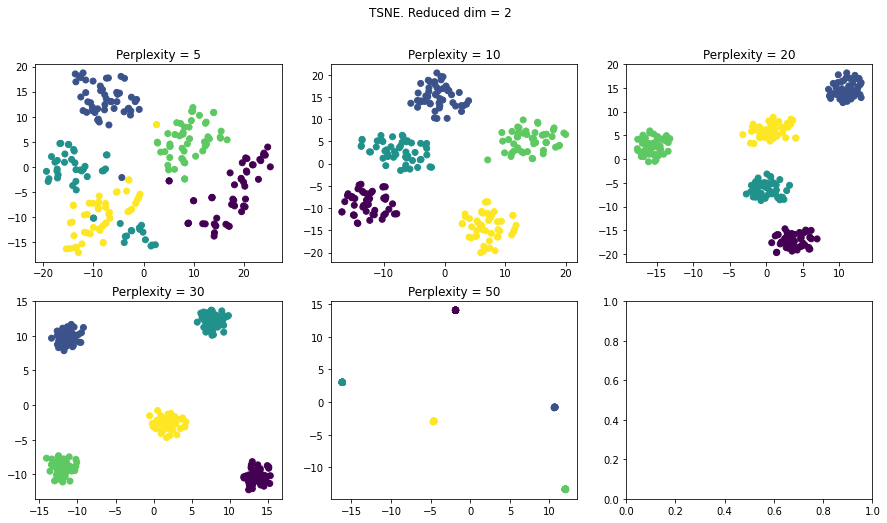

In [139]:
visualize_models(models)

So, as we see above all 5 clusters are well distinguishable and all clusters are right.
Accuracy also increases with `perplexity` parameter.

## Visualisation more complex data

Let's try to use TSNE for mnist dataset. 

In [236]:
# Load MNIST data
mndata = MNIST('./mnist')
images, labels = mndata.load_training()

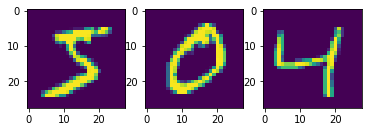

In [235]:
# Show some images from dataset
image1 = np.array(images[0]).reshape((28, 28))
image2 = np.array(images[1]).reshape((28, 28))
image3 = np.array(images[2]).reshape((28, 28))

_, ax = plt.subplots(1, 3)

ax[0].imshow(image1)
ax[1].imshow(image2)
ax[2].imshow(image3)

In [237]:
X = np.vstack(images)

X.shape

(60000, 784)

In [244]:
def get_data_from_mnist(X, labels, numbers: tp.Set[int], count_per_digit: int = 50) -> tp.Any:
    counts = defaultdict(int)

    tmp = []
    filtered_labels = []
    for point, n in zip(X, labels):
        if n not in numbers:
            continue

        counts[n] += 1
        tmp.append(point)
        filtered_labels.append(n)

        if counts[n] == count_per_digit:
            numbers.remove(n)
        
        if not numbers:
            break
    
    return np.vstack(tuple(tmp)), filtered_labels

In [260]:
# Take only 300 points: 100 samples on each of 3 digit
X_mnist, labels_mnist = get_data_from_mnist(X, labels, {0, 3, 6}, 100)

In [261]:
# Reduce dim from 784 to 30 with PCA
pca = PCA(n_components=30)

X_mnist = pca.fit_transform(X_mnist) / 100

In [262]:
X_mnist.shape

(300, 30)

In [263]:
model = TSNE(deepcopy(X_mnist), reduced_dim=2, perplexity=40, max_iterations=250, labels=labels_mnist)

In [264]:
# Reduce dimensions
model.fit()

Gradient descent: 100%|██████████| 250/250 [09:40<00:00,  2.32s/it]


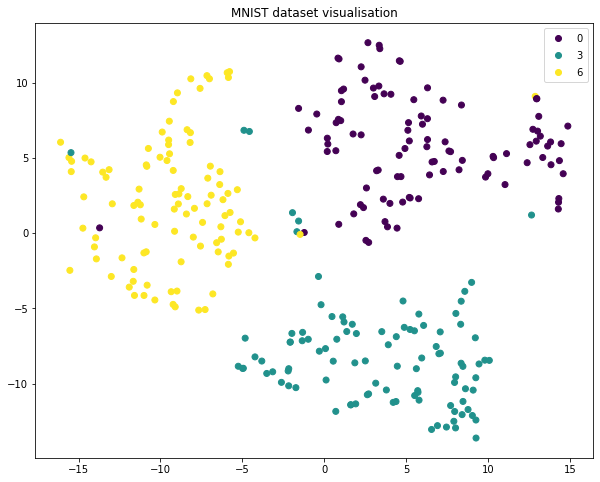

In [272]:
# Plotting result
points = model.out_points

plt.figure(figsize=(10, 8))
plt.title("MNIST dataset visualisation")
scatter = plt.scatter(points[:, 0], points[:, 1], c=model.labels)
plt.legend(*scatter.legend_elements())

As we see above algorithm works very well :)